<a href="https://colab.research.google.com/github/lab-jianghao/spark_ml_sample/blob/main/09_kmeans_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-17-jdk-headless

!wget https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz /content
!tar xf spark-3.5.0-bin-hadoop3.tgz

In [17]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [18]:
!pip install pyspark==3.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=033b860d40612982a18197b5386042b843233bd83cfe75f5c06547948d9a6e05
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [19]:
from functools import wraps
from pyspark.sql import SparkSession

def spark_sql_initializer(func):
    @wraps(func)
    def wrapper(*args, **kwargs):

        spark = SparkSession.builder\
            .appName("Colab_SPARK_ML")\
            .master("local[*]")\
            .getOrCreate()

        spark.sparkContext.setLogLevel("WARN")

        func(spark,*args, **kwargs)

        spark.stop()

    return wrapper

In [ ]:
!pip install openml

In [22]:
import openml
import pandas as pd

dataset = openml.datasets.get_dataset(43542, version=1.0)

print("Name:", dataset.name)
print("Description:", dataset.description)
print("Number of features:", dataset.features)
print("Number of instances:", dataset.qualities["NumberOfInstances"])


book_df, y, _, _ = dataset.get_data(target=dataset.default_target_attribute, dataset_format='dataframe')

print(book_df.head())


Name: 7k-Books
Description: Do we really need another dataset of books?
My initial plan was to build a toy example for a recommender system article I was writing. After a bit of googling, I found a few datasets. Sadly, most of them had some issues that made them unusable for me (e.g, missing description of the book, a mix of different languages but no column to specify the language per row or weird delimiters). 
So I decided to make a dataset that would match my purposes.
First, I got ISBNs from Soumik's Goodreads-books dataset. Using those identifiers, I crawled the Google Books API to extract the books' information.
Then, I merged those results with some of the original columns from the dataset and after some cleaning I got the dataset you see here.
What can I do with this?
Different Exploratory Data Analysis, clustering of books by topics/category, content-based recommendation engine using different fields from the book's description. 
Why is this dataset smaller than Soumik's Goodr

/usr/local/lib/python3.10/dist-packages/openml/datasets/functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


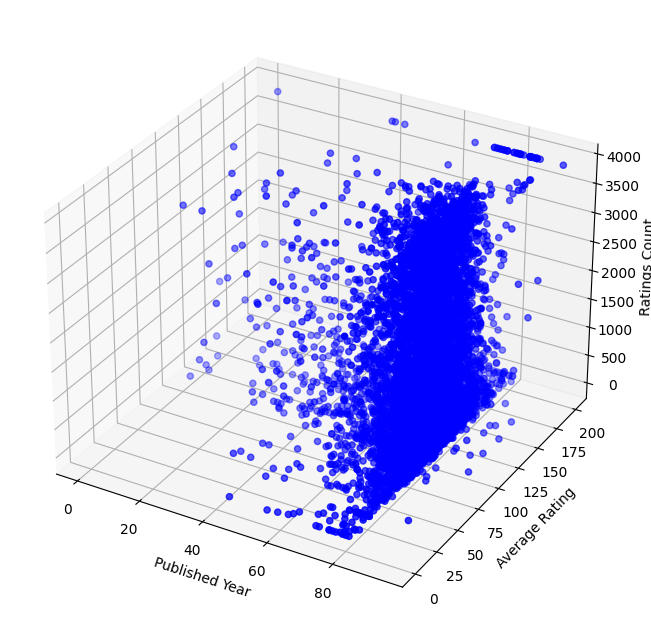

In [32]:
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import pandas as pd

selected_features = ["published_year", "average_rating", "ratings_count"]

book_df[selected_features] = book_df[selected_features].astype(float)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(book_df["published_year"], book_df["average_rating"], book_df["ratings_count"], s=20, c='b', marker='o')

ax.set_xlabel('Published Year')
ax.set_ylabel('Average Rating')
ax.set_zlabel('Ratings Count')

plt.show()


In [55]:
from pyspark.ml import Pipeline

from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.sql.functions import col

import matplotlib.pyplot as plt
import pandas as pd


@spark_sql_initializer
def train_kmeans(spark, df, k=3):
    book_df = spark.createDataFrame(df)
    book_df.show()

    index_columns = ['description', 'title', 'authors', 'categories']
    feature_indexes = [StringIndexer(inputCol=col, outputCol=f"indexed_{col}", handleInvalid="keep") for col in index_columns]
    for indexer in feature_indexes:
        book_df = indexer.fit(book_df).transform(book_df)

    feature_columns = [f"indexed_{col}" for col in index_columns] + ['average_rating', 'num_pages', 'ratings_count']

    vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    book_df = book_df.drop(*list(map(lambda idx_col: f"indexed_{idx_col}", index_columns)))

    kmeans = KMeans(featuresCol="features", predictionCol="prediction", k=k)

    kmeans_pipeline = Pipeline(stages=feature_indexes + [vector_assembler, kmeans])
    kmeans_model = kmeans_pipeline.fit(book_df)

    predictions = kmeans_model.transform(book_df)

    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance = " + str(silhouette))

    centers = kmeans_model.stages[-1].clusterCenters()
    print("Cluster Centers: ")
    for center in centers:
        print(center)

In [56]:
train_kmeans(book_df.copy())

+-------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------+---------+-------------+-------+
|       isbn13|    isbn10|               title|            subtitle|             authors|          categories|           thumbnail|         description|published_year|average_rating|num_pages|ratings_count|cluster|
+-------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------+---------+-------------+-------+
|9780002005883|0002005883|              Gilead|                NULL|  Marilynne Robinson|             Fiction|http://books.goog...|A NOVEL THAT READ...|          79.0|         104.0|    222.0|        354.0|      1|
|9780002261982|0002261987|        Spider's Web|             A Novel|Charles Osborne;A...|Detective and mys...|http://books.goog...|A new 'Ch

In [70]:
from pyspark.ml import Pipeline

from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.sql.functions import col

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


@spark_sql_initializer
def train_3_kmeans(spark, df, k=3):
    book_df = spark.createDataFrame(df)
    book_df.show()

    index_columns = ["published_year", "average_rating", "ratings_count"]

    vector_assembler = VectorAssembler(inputCols=index_columns, outputCol="features")

    kmeans = KMeans(featuresCol="features", predictionCol="prediction", k=k)

    kmeans_pipeline = Pipeline(stages=[vector_assembler, kmeans])
    kmeans_model = kmeans_pipeline.fit(book_df)

    predictions = kmeans_model.transform(book_df)

    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance = " + str(silhouette))

    centers = kmeans_model.stages[-1].clusterCenters()
    print("Cluster Centers: ")
    for center in centers:
        print(center)

    def inner_plt():

        predictions_pd = predictions.select("features", "prediction").toPandas()

        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(predictions_pd['features'].apply(lambda x: x[0]),
                predictions_pd['features'].apply(lambda x: x[1]),
                predictions_pd['features'].apply(lambda x: x[2]),
                c=predictions_pd['prediction'], cmap='viridis')

        centers_np = np.array(centers)
        ax.scatter(centers_np[:, 0], centers_np[:, 1], centers_np[:, 2], c='red', marker='x', s=200, label='Cluster Centers')

        ax.set_title('KMeans Clustering (3D)')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.set_zlabel('Feature 3')
        ax.legend()
        plt.show()

    inner_plt()


+-------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------+---------+-------------+-------+
|       isbn13|    isbn10|               title|            subtitle|             authors|          categories|           thumbnail|         description|published_year|average_rating|num_pages|ratings_count|cluster|
+-------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------+---------+-------------+-------+
|9780002005883|0002005883|              Gilead|                NULL|  Marilynne Robinson|             Fiction|http://books.goog...|A NOVEL THAT READ...|          79.0|         104.0|    222.0|        354.0|      1|
|9780002261982|0002261987|        Spider's Web|             A Novel|Charles Osborne;A...|Detective and mys...|http://books.goog...|A new 'Ch

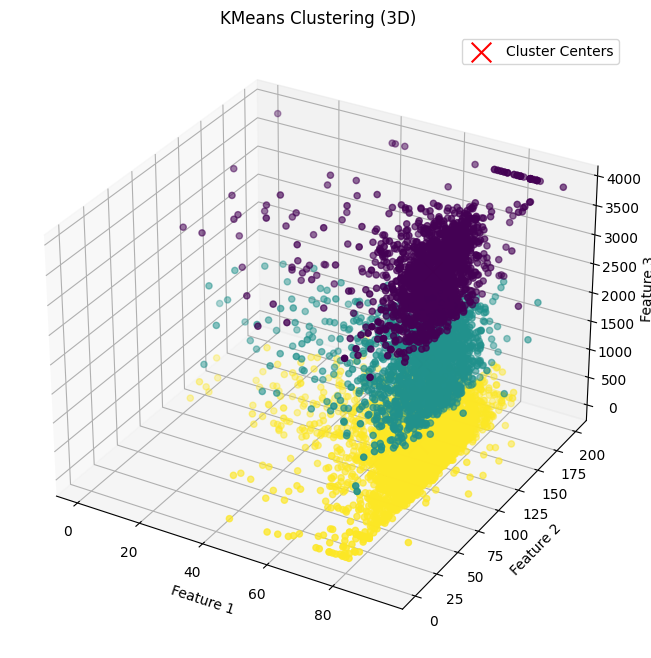

In [71]:
train_3_kmeans(book_df.copy())